In [119]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as random 
import re
from collections import Counter

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from matplotlib import cm

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
# Load the updated script data
df_script = pd.read_csv('data/Game_of_Thrones_Script_updated.csv')
df_script = df_script.dropna()

In [95]:
# preprocessing and TF-IDF functions

def preprocess_text(sentences):
    processed_text = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    for sentence in sentences:
        # Lowercase and remove non-alphanumeric characters
        sentence = re.sub(r'\W', ' ', sentence.lower())
        # Remove extra whitespace
        sentence = re.sub(r'\s+', ' ', sentence).strip()
        # Remove stopwords and lemmatize words
        words = nltk.word_tokenize(sentence)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_text.append(' '.join(words))

    return processed_text

def filter_text(sentences, filter_words):
    filtered_text = []
    sentences = preprocess_text(sentences)

    for sentence in sentences:
        sentence = sentence.split(' ')
        sentence = [word for word in sentence if word not in filter_words]
        filtered_text.append(' '.join(sentence))
    
    return filtered_text

def calculate_tfidf(documents, filter_words):
    preprocessed_documents = preprocess_text(documents)
    filtered_documents = filter_text(preprocessed_documents, filter_words)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(filtered_documents)
    return vectorizer, tfidf_matrix

def get_top_n_significant_words(vectorizer, tfidf_matrix, n=25):
    # Calculate the average TF-IDF score for each word
    avg_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)
    
    # Sort the words based on their average scores
    sorted_indices = np.argsort(avg_tfidf_scores)[::-1]
    
    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Select the top 25 words
    top_n_words = [feature_names[index] for index in sorted_indices[:n]]
    
    return top_n_words


In [69]:
# 1000 most common words in the sentences
sent_processed = preprocess_text(df_script['Sentence'])
# join the sentences to one document
sent_filtered = ' '.join(sent_processed)
# then split into words
sent_filtered = sent_filtered.split(' ')

Common1000Words = Counter(sent_filtered).most_common(1000)
Common1000Words = [word for word, count in Common1000Words]
# we still want king and queen because they are interesting.


In [79]:
# We make a list over words we like to see how fares in TF-IDF
interestingWords = 'wine drink fuck kill winter rape king queen whisper lord marry murder dragon bastard'.split(' ')

for word in interestingWords:
    Common1000Words.remove(word) if word in Common1000Words else None
len(Common1000Words)

988

In [96]:
documents = df_script['Sentence']

vectorizer, tfidf_matrix = calculate_tfidf(documents=documents, filter_words=Common1000Words)
print("Feature names:", vectorizer.get_feature_names_out())
print("TF-IDF matrix:\n", tfidf_matrix.toarray())

# documents

Feature names: ['11' '12' '120' ... 'zo' 'zuriff' 'ēza']
TF-IDF matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [97]:
# Get the top 25 most significant words according to TF-IDF scores
top_25_significant_words = get_top_n_significant_words(vectorizer, tfidf_matrix, 25)
print("Top 25 most significant words:", top_25_significant_words)

Top 25 most significant words: ['lord', 'king', 'queen', 'kill', 'dragon', 'bastard', 'fuck', 'drink', 'wine', 'murder', 'marry', 'winter', 'shae', 'terror', 'pa', 'crypt', 'agree', 'brandon', 'mm', 'loose', 'protecting', 'uh', 'honored', 'trick', 'nod']


In [100]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Calculate the average TF-IDF score for each word
avg_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)

# Create a dictionary with words as keys and their average scores as values
word_scores = {word: score for word, score in zip(feature_names, avg_tfidf_scores)}

for word in interestingWords:
    print(f"{word}: {word_scores[word]*100:.2f}%")


wine: 0.26%
drink: 0.33%
fuck: 0.34%
kill: 0.91%
winter: 0.17%
rape: 0.03%
king: 2.29%
queen: 1.12%
whisper: 0.03%
lord: 2.68%
marry: 0.18%
murder: 0.20%
dragon: 0.58%
bastard: 0.34%


In [102]:
# creating the wordcloud requires us to normalize the percentage usage of the words we want to include.
def normalize_frequencies(word_percentages):
    total_percentage = sum(word_percentages.values())
    normalized_frequencies = {word: percentage / total_percentage for word, percentage in word_percentages.items()}
    return normalized_frequencies

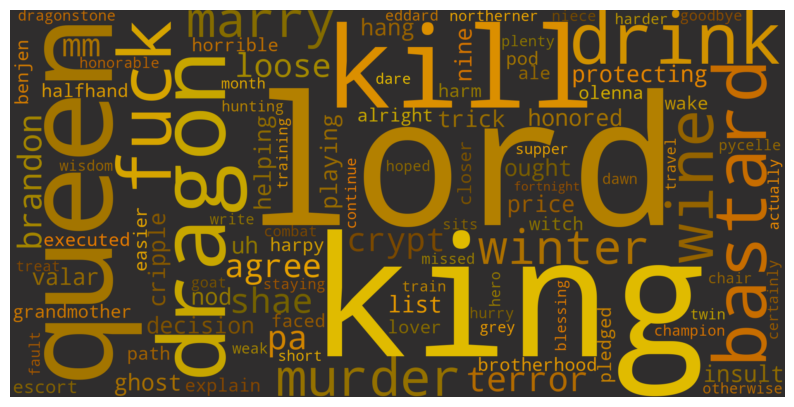

In [126]:
# we create a wordcloud for the top 100 most significant words according to TF-IDF scores
top_100_significant_words = get_top_n_significant_words(vectorizer, tfidf_matrix, 100)
top_100_significant_words = {word: score*100 for word, score in word_scores.items() if word in top_100_significant_words}

# two colors for the wordcloud

hsl_gray =  (23, 17, 91)
hsl_brown = (36, 13, 57)

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * float(random_state.randint(hsl_gray[0], hsl_brown[0])) / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)


normalized_frequencies = normalize_frequencies(top_100_significant_words)

wordcloud = WordCloud(width=2000, height=1000, background_color='#2f2d2d', color_func=random_color_func)
wordcloud.generate_from_frequencies(normalized_frequencies)

# Plot the wordcloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Save the word cloud as a high-resolution image
wordcloud.to_file('graphs/top100wordcloud.png')
